# OWA Anholt Array Efficiency: Benchmark Evaluation Script
*Javier Sanz Rodrigo, Fernando Borbón, Pedro Miguel Fernandes Correia, Pawel Gancarski (CENER)* 

*February 2019*

## Introduction
This is the model evaluation script for the [OWA-Anholt Array Efficiency benchmark](https://thewindvaneblog.com/the-owa-anholt-array-efficiency-benchmark-436fc538597d) as part of the [OWA Wake Modeling Challenge](https://www.carbontrust.com/media/677495/owa-wake-modelling-challenge_final-feb27.pdf).



## Simulations
The following models participate in the benchmark.

**Table 1. Participating models.**

| simID | Model | Type | Remarks |  
|:----:|:-----:|:----------:|:--------:|
| anh01 | XXX | time series  | - | 
| anh02 | XXX | time series  | - | 
| anh03 | XXX | time series  | - | 
| anh04 | XXX | time series  | - | 
| anh05 | XXX | time series  | - | 
| anh06 | XXX | time series  | - | 
| anh07 | XXX | bin averages | - | 

## Load libraries

In [1]:
%matplotlib inline
from src.WindConditions import *
from src.BinAvrg import *  
from scipy import interpolate

## Wind farm input data 
The scada_flags dataframe indicates which timestamps have been filtered out in the quality-control process of the SCADA data. This allows to perform the evaluation on validation dataset which only contains situations where the wind farm is operating in normal conditions.

In [2]:
# setup
datefrom = time_stamp(2013,1,1,0,0,0)    # evaluation period
dateto = time_stamp(2015,6,30,23,0,0)    # evaluation period

siteID = 'Anholt'
Hhub = 81.6         # hub-height
Drot = 120          # rotor diameter
lat_ref = 56.6      # degrees N 
lon_ref = 11.2      # degrees E

# Load manufacturer's power curve 
pwr_curve_file = pd.read_csv('./inputs/Anholt_pwc.csv', sep = ';')
pwr_curve_file['power'] = pwr_curve_file['power']/1000 # scale to MW
pwr_curve = interpolate.interp1d(pwr_curve_file['U'].values.flatten(),pwr_curve_file['power'].values.flatten(), 
                                bounds_error = False, fill_value = 0)
# when converting power to speed use the rev_pwr_curve
###rev_pwr_curve = interpolate.interp1d(pwr_curve_file['power'].values.flatten(),pwr_curve_file['U'].values.flatten())

# read_flags
# this file is provided to the participants so they can compute their bin-averages using the same timestamps of the validation data
scada_flags = pd.read_csv('./inputs/obs_flags.csv', index_col = 'time') 
min_data_availability = 90 #minimum allowed data availability in %
scada_ts = flags_to_ts(scada_flags, min_data_availability) # generate a list of accepted time series


## Wind conditions from mesoscale input data
In the absence of an *undisturbed* met mast, the wind farm centroid is used as reference site to define wind conditions and classify the wind climate in terms of wind direction sectors and stability classes. This site has also been used as the center of the innermost domain in the WRF set-up.

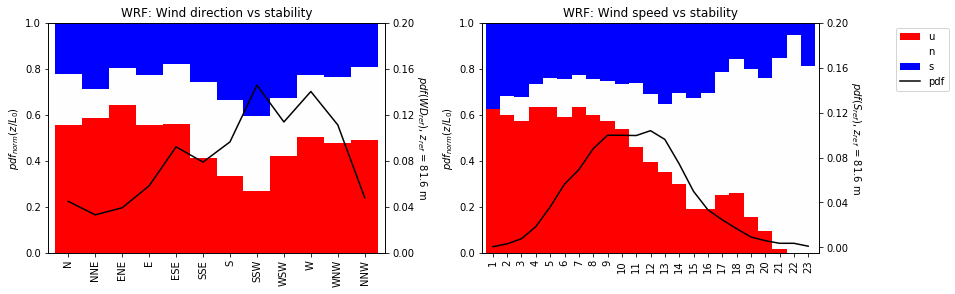

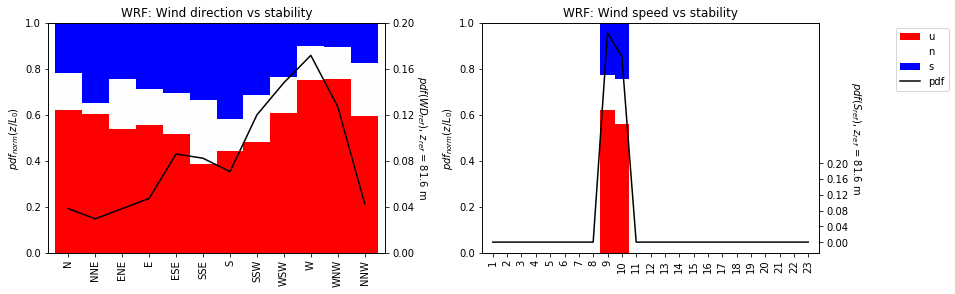

In [3]:
# Define bins to classify wind conditions 
Sbins = np.array([8,10])              # around the maximum of the trust coefficient 
WDbins = np.arange(-15.,360.+15.,30)  # wind direction bins (12 sectors)
WDbins_label = ['N','NNE','ENE','E','ESE','SSE',
                'S','SSW','WSW','W','WNW','NNW']
zLbins = [-0.2,-0.02, 0.02, 0.2]      # 3 stability bins
zLbins_label = ['u','n','s']

# interpolate to reference height
zref = Hhub         # [m]

# Load mesoscale data from the referent site (time-height profiles)
mast = WindConditions('./inputs/Anholt_Lav30km_ref.nc',lat_ref, lon_ref, siteID, datefrom, dateto)

#init the bin averaging class
bin_avrg = BinAvrg(datefrom, dateto, WDbins, WDbins_label, zLbins, zLbins_label)

#filter out speed restrictions
scada_ts = bin_avrg.filter_s(mast, zref, scada_ts, Sbins)

# Compute and plot distributions 
_ = mast.plot_stability(WDbins,WDbins_label,zLbins,zLbins_label,zref)

# after filtering
mast.reduce_to_ts(scada_ts)
N_WDzL,_,_,_,_ = mast.plot_stability(WDbins,WDbins_label,zLbins,zLbins_label,zref)

In [4]:
N_WDzL

,u,n,s
N,51.0,13.0,18.0
NNE,38.0,3.0,22.0
ENE,44.0,18.0,20.0
E,56.0,16.0,29.0
ESE,95.0,33.0,56.0
SSE,68.0,49.0,59.0
S,67.0,21.0,63.0
SSW,124.0,52.0,81.0
WSW,192.0,50.0,75.0
W,277.0,54.0,37.0


In [5]:
# create mapping of time stamps per wind direction and stability bins
# optionaly - filter out time stamps (scada_ts)
ts_bin_map = bin_avrg.create_ts_to_bin_map(mast, zref, scada_ts)

# Load mesoscale data at turbine positions (time-series at hub-height)
f = netCDF4.Dataset('./inputs/Anholt_WindTurbines.nc', 'r')
meso_ts_windspeed = pd.DataFrame(
            (f.variables['U'][:].data**2 + f.variables['V'][:].data**2)**0.5, 
            index = f.variables['Times'][:].data)
meso_ts_windspeed = restrict_to_ts(meso_ts_windspeed, scada_ts)

meso_ts = meso_ts_windspeed.transform(pwr_curve) # convert to power

# Compute bin-averaged (and std) quantities
meso_p, meso_p_std = bin_avrg.compute_mean(meso_ts, ts_bin_map)


## Load simulation data

In [6]:
# Loop through the submitted simulation data files and categorize them according to Table 1

sim_id =    ['anh01','anh02','anh03','anh04','anh05','anh06','anh07']
sim_model = ['ENG'  ,'RANS' ,'LES'  ,'RANS' ,'XXX'  ,'XXX', 'XXX']
sim_type =  ['ts'   ,'ts'   ,'ts'   ,'ts'   ,'ts'   ,'ts', 'ba']

n_sim = len(sim_id)
sim_ts = []
sim_P = []
sim_P_std = []

for isim in range(0,n_sim):
    file_name = './outputs/'+ sim_id[isim] +'.csv'
    ts = p = p_std =[]
    if sim_type[isim] == 'ts': 
        ts = pd.read_csv(file_name, index_col = 'time')  # read .csv output files
        p, p_std = bin_avrg.compute_mean(ts, ts_bin_map)   # from time-series to bin-averaged quantities
        # clean up the time series data and apply the scada_ts filter
        ts = restrict_to_ts(ts, scada_ts)
    else:
        p = bin_avrg.read_ba_file(file_name)
    sim_ts.append(ts)
    sim_P.append(p)
    sim_P_std.append(p_std)
    
# where sim[isim] is a 3D array: 
# Turbine # weind direction bin # stability bin  

## Load validation data
To increase the data availability, a machine learning algorithm has been applied to recover data from turbines that are not working in nominal conditions from others that do.

In [7]:
try:
    ts_obs = pd.read_csv('./observations/obs.csv', index_col = 'time') 
    p_obs, p_obs_std = bin_avrg.compute_mean(ts_obs, ts_bin_map)  
    # clean up the time series data and apply the scada_ts filter
    ts_obs = restrict_to_ts(ts_obs, scada_ts)
    val_data = True
except IOError:
    print ("No validation data available")
    val_data = False

## Compute quantities of interest and metrics
The *array efficiency* is defined based on the background wind speed at each turbine position:

$$ \eta = \frac{\sum_{i}P_i}{\sum_{i}P(S_i)} $$

where $P_i$ is the power of turbine $i$, observed or simulated, and $P(S_i)$ is the theoretical power from the manufaturer's power curve computed at the background (mesoscale) wind speed $S_i$ at each turbine position.  

Performance is measured in terms of the BIAS:

$$ BIAS = \eta_{obs} - \eta_{sim} $$ 

for each bin and for the whole wind distribution.

In [8]:
if val_data:
    p_ref = p_obs
    p_ref_std = p_obs_std
else: 
    #if no validation data is available, choose a dataset to compare with
    ref_sim = 0
    p_ref = sim_P[ref_sim]
    p_ref_std = sim_P_std[ref_sim]
    
eta_sim = []
bias = []
bias_tot = [] 
mean_abs_error = []
len_array = np.vectorize(len)
bin_sizes = len_array(ts_bin_map)
sum_bin_sizes = bin_sizes.sum()
if val_data:
    eta_ref = np.sum(p_ref,axis=0) / np.sum(meso_p,axis=0) # axis=0 are turbines
    eta_ref_std = np.sum(p_ref_std,axis=0) / np.sum(meso_p_std,axis=0)
    for isim in range(n_sim):
        eta_sim.append(np.sum(sim_P[isim],axis=0) / np.sum(meso_p,axis=0))
        bias.append(eta_ref - eta_sim[isim])
        bias_tot.append((bias[isim]*bin_sizes).sum()/sum_bin_sizes) 
        mean_abs_error.append((np.absolute(bias[isim])*bin_sizes).sum()/sum_bin_sizes) 

## Plot results

In [9]:
# Heatmaps: Plot eta_sim and associated bias vs WD-z/L bins

# Transect: Choose bin (WD,zL), define list of turbines and plot profiles of array efficiency along the transect of turbines. 
#           Normalized by dividing with eta of the first turbine in the list
#           Use error bars showind one std about the observed array efficiency (eta_obs_std)
